# Weather Dataset Analysis 

This notebook examines the weather datasets from Meteostat (retrieved from https://meteostat.net/de/ on 25th november 2022). The dataset is used as a vertical use case for cross-silo federated learning. The goal is to predict the air temperature for a single weather station, given a selection of attributes of the last *n* days from this station.

## Dataset Description

In [1]:
#import dependencies
import numpy as np
import pandas as pd
import seaborn as sns

from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../scripts')
import helper

2023-02-03 16:20:18.479253: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-03 16:20:20.810604: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-03 16:20:20.810781: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-03 16:20:20.810789: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
#load dataset
#the weather station Berlin Alexanderplatz is chosen as the examplary station
data = pd.read_csv("../datasets/vertical/weather/berlin_alexanderplatz.csv", names=["time", "temp", "dwpt", "rhum", "prcp", "snow", "wdir", "wspd", "wpgt", "pres", "tsun", "coco"])
data.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,1969-12-02,-1.3,-4.5,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1969-12-03,1.5,1.0,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1969-12-04,-0.5,-2.0,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1969-12-05,-3.2,-5.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1969-12-06,-2.1,-3.5,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,16515.0,10.608653,7.861329,-17.6,4.6,10.6,16.8,31.1
dwpt,16513.0,7.365076,6.997318,-18.7,2.2,7.4,13.0,24.7
rhum,16514.0,14.120358,8.975399,-14.9,7.1,14.1,21.1,38.0
prcp,11987.0,1.579361,3.642694,0.0,0.0,0.0,1.5,60.4
snow,4117.0,5.176099,23.663484,0.0,0.0,0.0,0.0,310.0
wdir,10598.0,208.351670,93.444179,0.0,131.0,235.0,280.0,360.0
wspd,11034.0,28.778204,15.034219,0.0,16.6,26.6,38.9,115.2
wpgt,8395.0,53.423204,21.768710,0.0,36.0,51.5,67.7,154.8
pres,11936.0,1010.997009,9.549732,961.3,1005.2,1011.3,1017.2,1044.8
tsun,31.0,15.483871,60.651942,0.0,0.0,0.0,0.0,276.0


[Text(0.5, 1.0, 'Measured temperature at Berlin Alexanderplatz')]

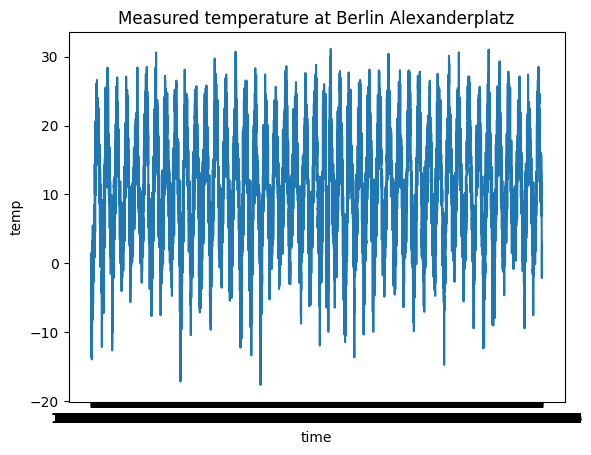

In [4]:
sns.lineplot(data, x="time", y="temp").set(title="Measured temperature at Berlin Alexanderplatz")

[Text(0.5, 1.0, 'Measured temperature at Berlin Alexanderplatz within the last 365 days')]

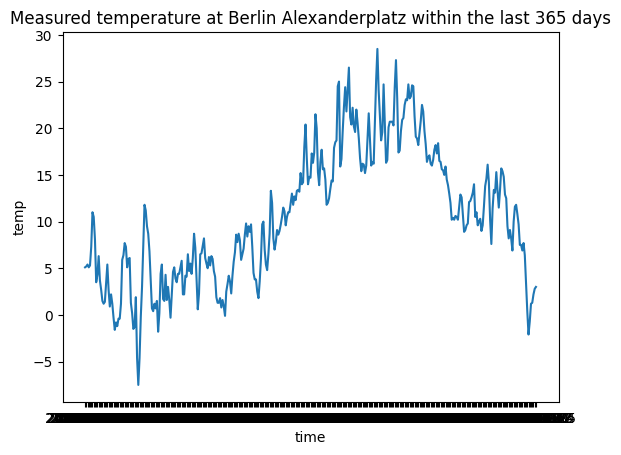

In [5]:
sns.lineplot(data.iloc[-365:], x="time", y="temp").set(title="Measured temperature at Berlin Alexanderplatz within the last 365 days")

/tmp/ipykernel_2286/2634944063.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


<AxesSubplot: >

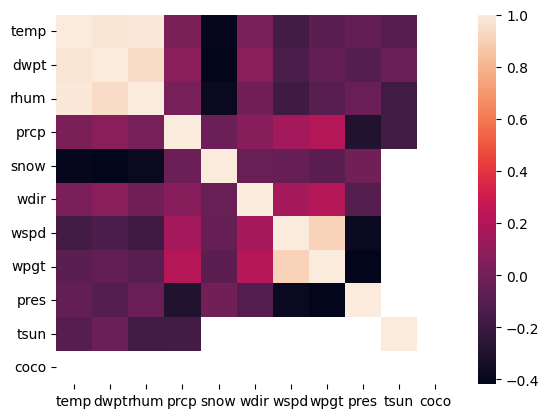

In [6]:
corr = data.corr()
sns.heatmap(corr, xticklabels=True, yticklabels=True)


In [7]:
corr.temp.describe()

count    10.000000
mean      0.220346
std       0.542975
min      -0.400857
25%      -0.096518
50%      -0.016535
75%       0.738686
max       1.000000
Name: temp, dtype: float64

In [8]:
corr.temp.sort_values(ascending=False).head(n=10)

temp    1.000000
rhum    0.987750
dwpt    0.976184
prcp    0.026191
wdir    0.023584
pres   -0.056654
wpgt   -0.086019
tsun   -0.100018
wspd   -0.166704
snow   -0.400857
Name: temp, dtype: float64

## Model Parameter Selection

This section finds the optimal parameters for models trained on the weather datasets. The selected attributes are *temp*, *rhum* and *dwpt*. Althought *snow* has a correlation of around -0.4 it is left out because only a fraction of records actually include this attribute. This is also the case for the other weather stations.

In [63]:
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np


def _get_samples_from_weather_data(n: int, attributes: list[str], station: str, num_of_samples: int):
    """
    Generates samples from the covid dataset.
    Args:
        n (int): Numbers of records per sample.
        attributes (list[str]): List of attributes that will be used from the dataset. The fist element is the endogene variable.
        station (str): Name of the station.
        num_of_samples (int): Number of returned samples.
    """



    #load data
    path = f"/home/florian/bachelorarbeit/code/Cross-Silo-FL/datasets/vertical/weather/{station}.csv"
    data = pd.read_csv(path, names=["time", "temp", "dwpt", "rhum", "prcp", "snow", "wdir", "wspd", "wpgt", "pres", "tsun", "coco"])
    data = data[attributes]
    data = data.dropna()
    #scale the data
    # data = data.drop("time", axis=1)
    # data_columns = data.columns
    # scaler = StandardScaler()
    # scaled_data = scaler.fit_transform(data)
    # data = pd.DataFrame(scaled_data, columns=data_columns)

    X = np.empty(shape=(num_of_samples, n))
    y = np.empty(shape=(num_of_samples,))


    #split the data
    splitter = SlidingWindowSplitter(fh=1, window_length=n)
    samples = splitter.split_series(data[attributes].to_numpy())

    i = 0
    for features, label in samples:
        X[i] = features.flatten()
        y[i] = label

        i += 1

        if i == num_of_samples:
            break

    return X, y


In [64]:
X, y  = _get_samples_from_weather_data(10, ["temp"], "berlin_alexanderplatz", 10000)

In [41]:
X.shape

(10000, 10)

In [42]:
y.shape

(10000, 1)

In [55]:
X[:2]

array([[-1.3,  1.5, -0.5, -3.2, -2.1, -2.4, -3.2, -3.8, -3.4,  0.4],
       [ 1.5, -0.5, -3.2, -2.1, -2.4, -3.2, -3.8, -3.4,  0.4,  0.5]])

In [56]:
y[:2]

array([[ 0.5],
       [-0.9]])

In [65]:
attributes = ["temp", "rhum", "dwpt"]
samples = _get_samples_from_weather_data( 10, ["temp"], "berlin_alexanderplatz", 100000)
samples

(array([[-1.3,  1.5, -0.5, ..., -3.8, -3.4,  0.4],
        [ 1.5, -0.5, -3.2, ..., -3.4,  0.4,  0.5],
        [-0.5, -3.2, -2.1, ...,  0.4,  0.5, -0.9],
        ...,
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]]),
 array([ 0.5, -0.9, -1.6, ...,  0. ,  0. ,  0. ]))

## Linear Regression

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

In [13]:
lm_params = {"fit_intercept": [True, False], "positive": [True, False]}
lm = LinearRegression()
lm_grid = GridSearchCV(lm, lm_params, scoring="neg_mean_absolute_error")

lm_grid.fit(samples[0], samples[1])
lm_grid.best_params_

{'fit_intercept': True, 'positive': False}

In [71]:
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(samples[0], samples[1])

Ridge()

In [73]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(samples[1], ridge.predict(samples[0]))

0.29106164033841

## Linear Support Vector Machine

In [60]:
from sklearn.svm import LinearSVR

In [69]:
svm_params = {"epsilon": [0,0.1,0.5,1,2,5,10], "tol": [0.0001, 0.001, 0.01, 0.1, 1, 0.00001], "C": [0.1,0.2,0.5,1,2,5,10]}
svm = LinearSVR()
svm_grid = GridSearchCV(svm, svm_params, scoring="neg_mean_absolute_error")

svm_grid.fit(samples[0], samples[1])

/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinea

KeyboardInterrupt: 

In [78]:
svm = LinearSVR(max_iter=10000).fit(samples[0], samples[1])

/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [77]:
import tensorflow as tf

model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(16, input_shape=(10,)))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(1, activation="linear"))

model.compile(optimizer="adam", loss="mae")
hist = model.fit(samples[0], samples[1], batch_size=32, epochs=5)

Epoch 1/5
3125/3125 [==============================] - 4s 1ms/step - loss: 0.3116
Epoch 2/5
3125/3125 [==============================] - 4s 1ms/step - loss: 0.2929
Epoch 3/5
3125/3125 [==============================] - 4s 1ms/step - loss: 0.2893
Epoch 4/5
3125/3125 [==============================] - 3s 1ms/step - loss: 0.2874
Epoch 5/5
3125/3125 [==============================] - 3s 1ms/step - loss: 0.2874


In [14]:
svm_grid.best_params_

{'C': 0.2, 'epsilon': 0.1, 'tol': 1e-05}

## Multi-Layer Perceptron

In [15]:
import keras_tuner as kt
import tensorflow as tf

In [16]:
#build a sequential model
def build_model(hp):
    input_shape = np.array(samples[0]).shape[1]
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(input_shape,)))

    #add dense layers to the model
    for i in range(hp.Int('number of layers', min_value=1, max_value=6)):
        neurons = hp.Int('layer_' + str(i), min_value=8, max_value=512, step=8)
        model.add(tf.keras.layers.Dense(neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation="relu"))

    hp_learning_rate = hp.Choice("learning_rate", values=[0.1, 0.01, 0.001, 0.0001])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=tf.keras.losses.MeanAbsoluteError(),
        metrics=["mean_absolute_error"])

    return model


tuner = kt.Hyperband(build_model,
                     objective="mean_absolute_error",
                     max_epochs=10,
                     factor=3,
                     directory= "./keras_tuner/weather/",
                     project_name= "weather_mlp_params")

stop_early = tf.keras.callbacks.EarlyStopping(monitor= "val_loss", patience=5)

tuner.search(np.array(samples[0]), np.array(samples[1]), validation_split=0.2, epochs=50, callbacks=[stop_early, tf.keras.callbacks.TensorBoard("./keras_tuner/covid/covid_tb_logs")])

tuner.results_summary()

Trial 30 Complete [00h 00m 27s]
mean_absolute_error: 0.5396388173103333

Best mean_absolute_error So Far: 0.5375256538391113
Total elapsed time: 00h 03m 34s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./keras_tuner/weather/weather_mlp_params
Showing 10 best trials
Trial summary
Hyperparameters:
number of layers: 6
layer_0: 192
learning_rate: 0.0001
layer_1: 184
layer_2: 72
layer_3: 496
layer_4: 16
layer_5: 368
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0022
Score: 0.5375256538391113
Trial summary
Hyperparameters:
number of layers: 6
layer_0: 136
learning_rate: 0.0001
layer_1: 112
layer_2: 216
layer_3: 104
layer_4: 120
layer_5: 440
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0013
Score: 0.5382292866706848
Trial summary
Hyperparameters:
number of layers: 4
layer_0: 488
learning_rate: 0.0001
layer_1: 216
layer_2: 216
layer_3: 464
layer_4: 496
layer_5: 248
tuner/epochs: 4
tuner/ini

In [17]:
best_model = tuner.get_best_models()[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 192)               5952      
                                                                 
 dense_1 (Dense)             (None, 184)               35512     
                                                                 
 dense_2 (Dense)             (None, 72)                13320     
                                                                 
 dense_3 (Dense)             (None, 496)               36208     
                                                                 
 dense_4 (Dense)             (None, 16)                7952      
                                                                 
 dense_5 (Dense)             (None, 368)               6256      
                                                                 
 dense_6 (Dense)             (None, 1)                 3

## Baseline Models

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [19]:
X_train, X_test, y_train, y_test = train_test_split(samples[0], samples[1], test_size=0.3)

In [20]:
baseline_lm = LinearRegression(**lm_grid.best_params_)
baseline_lm.fit(X_train, y_train)

baseline_lm_MAE = mean_absolute_error(y_test, baseline_lm.predict(X_test))
baseline_lm_MSE = mean_squared_error(y_test, baseline_lm.predict(X_test))
baseline_lm_R2 = r2_score(y_test, baseline_lm.predict(X_test))

In [21]:
baseline_svm = LinearSVR(**svm_grid.best_params_)
baseline_svm.fit(X_train, y_train)

baseline_svm_MAE = mean_absolute_error(y_test, baseline_svm.predict(X_test))
baseline_svm_MSE = mean_squared_error(y_test, baseline_svm.predict(X_test))
baseline_svm_r2 = r2_score(y_test, baseline_svm.predict(X_test))

/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [23]:
baseline_mlp = tf.keras.Sequential()
input_shape = np.array(samples[0]).shape[1]
baseline_mlp.add(tf.keras.layers.Input(shape=input_shape))
baseline_mlp.add(tf.keras.layers.Dense(192))
baseline_mlp.add(tf.keras.layers.Dense(184))
baseline_mlp.add(tf.keras.layers.Dense(72))
baseline_mlp.add(tf.keras.layers.Dense(496))
baseline_mlp.add(tf.keras.layers.Dense(16))
baseline_mlp.add(tf.keras.layers.Dense(368))
baseline_mlp.add(tf.keras.layers.Dense(1))

baseline_mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.MeanAbsoluteError(),
        metrics=["mean_absolute_error", "mean_squared_error"])

stop_early = tf.keras.callbacks.EarlyStopping(monitor= "loss", patience=5)

baseline_mlp.fit(np.array(X_train), np.array(y_train), epochs=100, callbacks=[stop_early])

result = baseline_mlp.evaluate(np.array(X_test), np.array(y_test))
baseline_mlp_metrics = dict(zip(baseline_mlp.metrics_names, result))

Epoch 1/100
356/356 [==============================] - 2s 3ms/step - loss: 0.2553 - mean_absolute_error: 0.2553 - mean_squared_error: 0.1202
Epoch 2/100
356/356 [==============================] - 1s 3ms/step - loss: 0.2187 - mean_absolute_error: 0.2187 - mean_squared_error: 0.0795
Epoch 3/100
356/356 [==============================] - 1s 2ms/step - loss: 0.2179 - mean_absolute_error: 0.2179 - mean_squared_error: 0.0790
Epoch 4/100
356/356 [==============================] - 1s 3ms/step - loss: 0.2157 - mean_absolute_error: 0.2157 - mean_squared_error: 0.0778
Epoch 5/100
356/356 [==============================] - 1s 2ms/step - loss: 0.2173 - mean_absolute_error: 0.2173 - mean_squared_error: 0.0784
Epoch 6/100
356/356 [==============================] - 1s 2ms/step - loss: 0.2162 - mean_absolute_error: 0.2162 - mean_squared_error: 0.0775
Epoch 7/100
356/356 [==============================] - 1s 2ms/step - loss: 0.2145 - mean_absolute_error: 0.2145 - mean_squared_error: 0.0769
Epoch 8/100
3

In [24]:
print(f"""
Linear Regression \n
MSE: {baseline_lm_MSE} \n
MAE: {baseline_lm_MAE} \n
R2: {baseline_lm_R2} \n
----------------------\n
Support Vector Machine \n
MSE: {baseline_svm_MSE} \n
MAE: {baseline_svm_MAE} \n
R2: {baseline_svm_r2} \n
----------------------\n
Multi-Layer Perceptron \n
Loss: {baseline_mlp_metrics["loss"]} \n
MSE: {baseline_mlp_metrics["mean_squared_error"]} \n
MAE: {baseline_mlp_metrics["mean_absolute_error"]}
""")


Linear Regression 

MSE: 0.07699060927031325 

MAE: 0.2137768840472443 

R2: 0.9236213919893526 

----------------------

Support Vector Machine 

MSE: 0.07749309052620372 

MAE: 0.213065539293761 

R2: 0.923122904975935 

----------------------

Multi-Layer Perceptron 

Loss: 0.21551470458507538 

MSE: 0.07973022758960724 

MAE: 0.21551470458507538

